#### Setup

In [15]:
from qiskit_transpiler import get_pm
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_provider import IBMProvider
from qiskit_experiments.library import InterleavedRB
import qiskit.circuit.library as circuits
from qiskit import QuantumCircuit

In [16]:
#Setting the IBM provider
api_file = "../../../ibm_API_key"
with open(api_file, "r") as f:
        api_key = f.readline().strip()
provider = IBMProvider(api_key, instance='ibm-q-ncsu/nc-state/quantum-compiler')
backend = provider.get_backend('ibmq_mumbai')

#### Circuit to only pass as a gate

In [17]:
gate_circuit = QuantumCircuit(2, name='custom_rzx')
gate_circuit.rzx(np.pi/2,0,1)
custom_rzx = gate_circuit.to_gate()

#### Circuit to pass for getting the calibration specific to the qubit

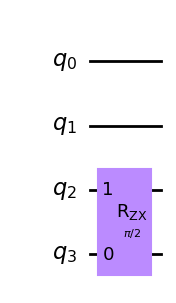

In [18]:
calibration_circuit = QuantumCircuit(4)
calibration_circuit.rzx(np.pi/2,3,2)
calibration_circuit.draw('mpl')

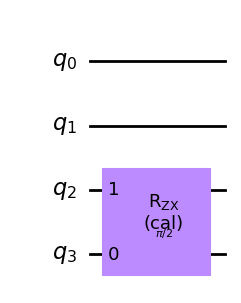

In [19]:
pm = get_pm(backend)
calibrated_circuit = pm.run(calibration_circuit)
calibrated_circuit.draw('mpl')

In [20]:
calibrated_circuit.calibrations

{'rzx': {((3, 2),
   (1.5707963267948966,)): ScheduleBlock(ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=688, sigma=64, width=432.0, amp=0.24908578739715784, angle=-1.9544697125140549), ControlChannel(6)), name="rescale_cr_inst", transform=AlignLeft()), ScheduleBlock(Play(GaussianSquare(duration=688, sigma=64, width=432.0, amp=0.04332670533667969, angle=-0.033645972852721674), DriveChannel(2)), name="rescale_cr_inst", transform=AlignLeft()), name="block8", transform=AlignLeft()), ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-0.7940464413113942, amp=0.16136684418719055, angle=0.0, name='Xp_d3'), DriveChannel(3), name='Xp_d3'), name="x", transform=AlignLeft()), ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=688, sigma=64, width=432.0, amp=0.24908578739715787, angle=1.1871229410757382), ControlChannel(6)), name="rescale_cr_inst", transform=AlignLeft()), ScheduleBlock(Play(GaussianSquare(duration=688, sigma=64, width=432.0, amp=0.04332670533667969, angle=3.1079

In [21]:
calibration = list(calibrated_circuit.calibrations['rzx'].values())[0]
calibration

ScheduleBlock(ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=688, sigma=64, width=432.0, amp=0.24908578739715784, angle=-1.9544697125140549), ControlChannel(6)), name="rescale_cr_inst", transform=AlignLeft()), ScheduleBlock(Play(GaussianSquare(duration=688, sigma=64, width=432.0, amp=0.04332670533667969, angle=-0.033645972852721674), DriveChannel(2)), name="rescale_cr_inst", transform=AlignLeft()), name="block8", transform=AlignLeft()), ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-0.7940464413113942, amp=0.16136684418719055, angle=0.0, name='Xp_d3'), DriveChannel(3), name='Xp_d3'), name="x", transform=AlignLeft()), ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=688, sigma=64, width=432.0, amp=0.24908578739715787, angle=1.1871229410757382), ControlChannel(6)), name="rescale_cr_inst", transform=AlignLeft()), ScheduleBlock(Play(GaussianSquare(duration=688, sigma=64, width=432.0, amp=0.04332670533667969, angle=3.1079466807370713), DriveChannel(2)), name="rescal

In [22]:
backend.target.add_instruction(custom_rzx, {(3,2): InstructionProperties(calibration=calibration)})

In [23]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = (3,2) # make sure it is the qubit added in the backend target

int_exp = InterleavedRB(
    custom_rzx, qubits, lengths, num_samples=num_samples, seed=seed, backend=backend)

In [24]:
int_expdata = int_exp.run(backend).block_for_results()
int_results = int_expdata.analysis_results()

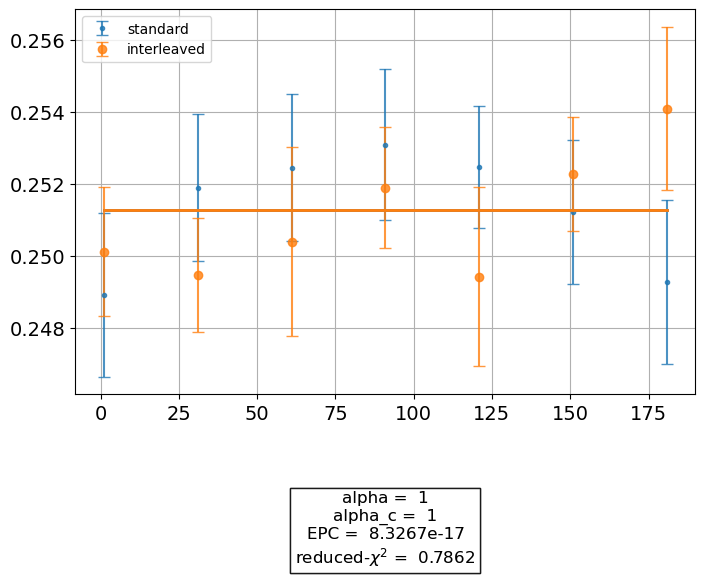

AnalysisResult
- name: @Parameters_InterleavedRBAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 2
  * F_standard(x) = a * alpha ** x + b
  * F_interleaved(x) = a * (alpha_c * alpha) ** x + b
 - success: True
 - number of function evals: 40
 - degree of freedom: 10
 - chi-square: 7.861628019349777
 - reduced chi-square: 0.7861628019349778
 - Akaike info crit.: -0.07889064469579488
 - Bayesian info crit.: 2.4773386737652388
 - init params:
  * a = 0.0
  * alpha = 0.996405074835924
  * b = 0.25
  * alpha_c = 1.0
 - fit params:
  * a = 1.4687403598332524e-15
  * alpha = 0.9999999996509948
  * b = 0.25126696564428896
  * alpha_c = 0.9999999999999999
- quality: good
- device_components: ['Q3', 'Q2']
- verified: False
AnalysisResult
- name: alpha
- value: 0.9999999996509948+/-nan
- χ²: 0.7861628019349778
- quality: good
- device_components: ['Q3', 'Q2']
- verified: False
AnalysisResult
- name: alpha_c
- value: 0.9999999999999999+/-nan
- χ²: 0.786162

In [25]:
# View result data
display(int_expdata.figure(0))
for result in int_results:
    print(result)

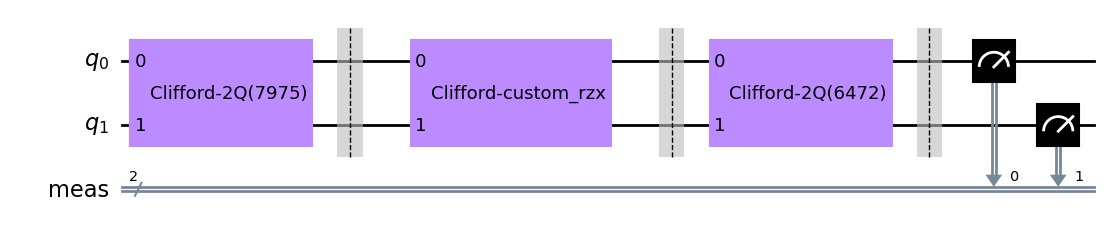

In [26]:
int_exp.circuits()[1].draw(output='mpl')

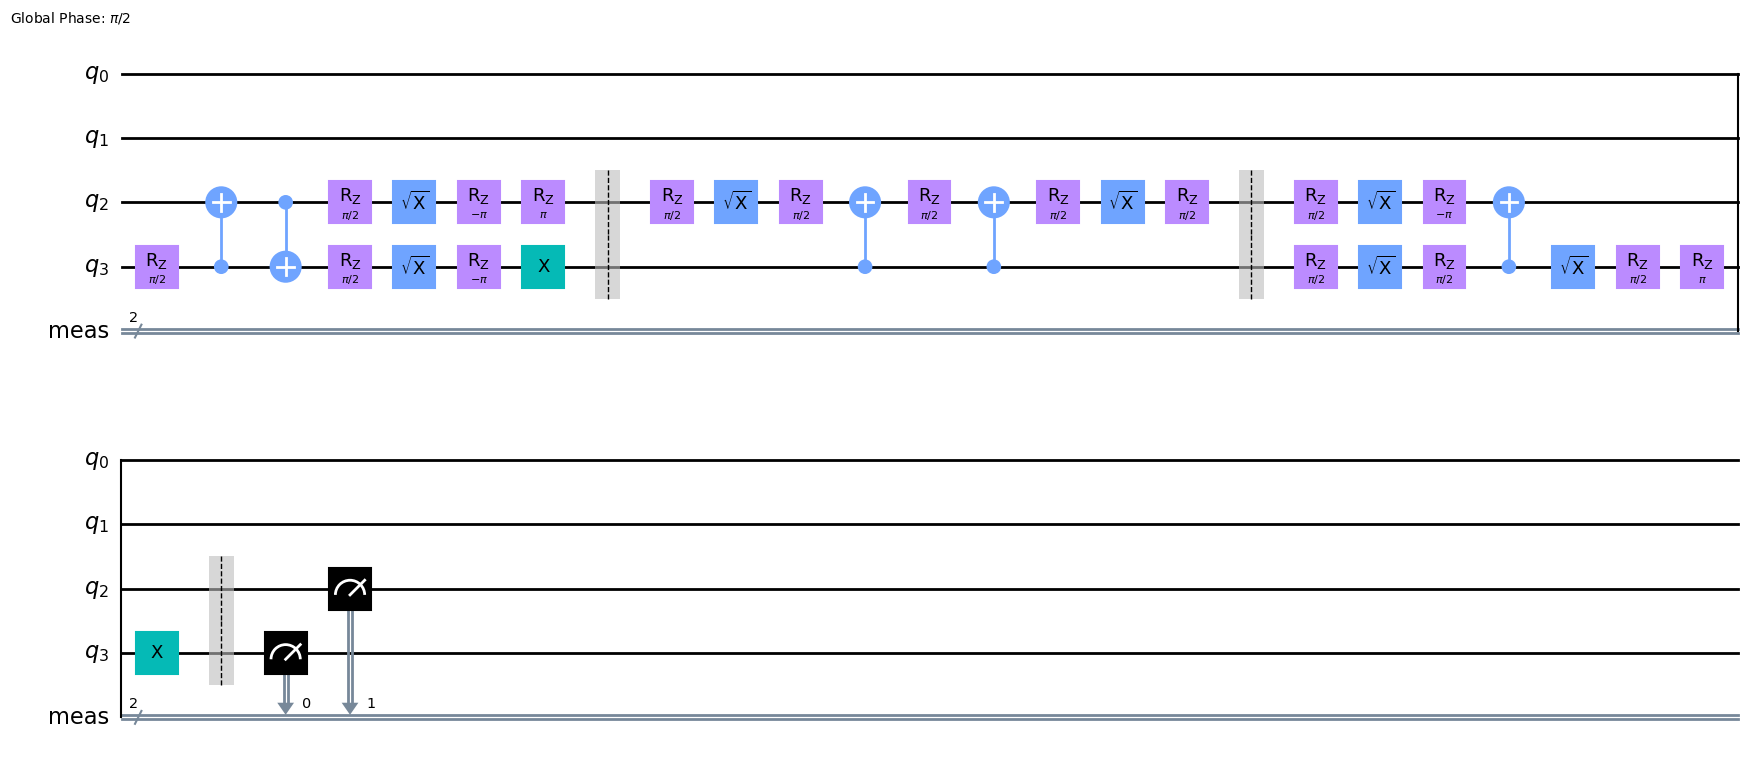

In [27]:
# you can see that the transpiled circuits contain the calibrations
int_exp._transpiled_circuits()[1].draw(output='mpl')